In [89]:
# we can use multiple data sources for this
# Flukebook
from __future__ import division, print_function
from os.path import join
import cPickle as pickle


with open('../dataset_loc', 'r') as f:
    dataset_loc = f.read().rstrip()
    
with open(join(dataset_loc, 'Flukes/Flukebook/flukebook_points_orig.pkl'), 'r') as f:
    fb_points = pickle.load(f)
print(len(fb_points))

1577


In [90]:
# Zooniverse
with open(join(dataset_loc, 'ibs_points_allindv.pkl'), 'r') as f:
    zsl_points = pickle.load(f)
    
print(len(zsl_points))

1970


In [91]:
# Our own annotations
from glob import glob
import json
annotation_path = "/home/andrew/envs/whaleFlukes/whale_edge_annotations/annotation_info"

all_annotations = glob(join(annotation_path, '*'))
annotation_points = []
for annotation_fn in all_annotations:
    with open(annotation_fn, 'r') as f:
        annotation = json.load(f)
        if annotation[1]['done'] and not annotation[1]['bad'] and not annotation[1]['notchSubmerged']:
            this_annot = {'fn':annotation[0]}
            this_annot['left'] = annotation[1]['topInfo']['path'][-1]
            this_annot['right'] = annotation[1]['topInfo']['path'][0]
            this_annot['notch'] = annotation[1]['notch']
            annotation_points.append(this_annot)
print(len(annotation_points))

489


In [92]:
fb_imgs_dir = join(dataset_loc, "Flukes/Flukebook/images")
zsl_and_annot_imgs_dir  = join(dataset_loc, "Flukes/CRC_combined constrained")

In [113]:
import cv2
import numpy as np

#fixed_shape = (224, 224) # so I can transfer over Imagenet trained models
fixed_shape = (64, 64) # so I can minimize size of network


def resize_point(new_shape, old_shape, point):
    # check that the point is inside the bounds of the image
    if ((point[0] < 0) or (point[0] > old_shape[1])) or ((point[1] < 0) or (point[1] > old_shape[0])):
        print("Point %s is out of bounds for shape %s" % (point, old_shape))
        raise IndexError("Point is out of bounds")
    # assume point is x, y
    scale_x = new_shape[1] / old_shape[1]
    scale_y = new_shape[0] / old_shape[0]
    
    new_pt = np.array([int(point[0]*scale_x), int(point[1]*scale_y)]).reshape(1,-1)
    return new_pt

def convert_img_points(new_size, img, left, right, notch):
    # assume new_size is y, x (makes sense for everything except cv2)
    resized_img = cv2.resize(img, new_size[::-1])

    resized_left = resize_point(new_size, img.shape, left)
    resized_right = resize_point(new_size, img.shape, right)
    resized_notch = resize_point(new_size, img.shape, notch)
    
    return resized_img, np.vstack([resized_left, resized_right, resized_notch])
    
xyc = lambda pt: (pt['x'], pt['y'])
    
# these need to stay parallel
fb_kp_imgs = []
fb_kp_pts = []
for annot in fb_points:
    img = cv2.imread(join(fb_imgs_dir, annot['fn']))
    try:
        resized_img, res_points = convert_img_points(fixed_shape, img, 
                                         xyc(annot['points']['left']), xyc(annot['points']['right']), 
                                                                         xyc(annot['points']['notch']))
    except IndexError as ie:
        print("Bad points on image %s" % annot['fn'])
        continue
    fb_kp_imgs.append(resized_img)
    fb_kp_pts.append(res_points)
# guide: so each of <src>_kp_pts is going to be a matrix where each row is the x, y coords of each point in 
# left, right, notch respectively

Point (1971, 134) is out of bounds for shape (600, 800, 3)
Bad points on image extract24e6f12b-1510-440f-8058-139d1f4a1074.jpg
Point (2243, 33) is out of bounds for shape (600, 800, 3)
Bad points on image extract260871e1-2126-4274-b740-1087ef54ab1d.jpg
Point (1725, 15) is out of bounds for shape (600, 800, 3)
Bad points on image extract277df90a-dff2-409b-b78a-a6c27c3a3a50.jpg
Point (1876, 28) is out of bounds for shape (600, 800, 3)
Bad points on image extract3242b464-273b-42f9-abb3-69d514197ac8.jpg
Point (2179, 54) is out of bounds for shape (600, 800, 3)
Bad points on image extract3f98b0ab-b393-49f4-8e74-8962ac4c55ad.jpg
Point (1685, 45) is out of bounds for shape (600, 800, 3)
Bad points on image extract40a1698b-0720-4899-8643-950812bfa102.jpg
Point (2328, 102) is out of bounds for shape (600, 800, 3)
Bad points on image extract472310a6-8ad1-449a-851d-87347399a603.jpg
Point (1471, 54) is out of bounds for shape (600, 800, 3)
Bad points on image extract47e2db01-c410-4651-98e6-b0ff0b2

In [114]:
zsl_kp_imgs = []
zsl_kp_pts = []

seen_imgs = set()

zsl_points.keys()

for imgn in zsl_points:
    img = cv2.imread(join(zsl_and_annot_imgs_dir, imgn))
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        zsl_points[imgn]['left'], zsl_points[imgn]['right'], 
                                                                     zsl_points[imgn]['notch'])
    seen_imgs.add(imgn)
    zsl_kp_imgs.append(resized_img)
    zsl_kp_pts.append(res_points)

In [115]:
annot_kp_imgs = []
annot_kp_pts = []

for annot in annotation_points:
    if annot['fn'] in seen_imgs:
        print("Already saw %s in the ZSL data, skipping" % annot['fn'])
        continue
    img = cv2.imread(join(zsl_and_annot_imgs_dir, imgn))
    resized_img, res_points = convert_img_points(fixed_shape, img,
                                        annot['left'], annot['right'], annot['notch'])
    annot_kp_imgs.append(resized_img)
    annot_kp_pts.append(res_points)

Already saw 13716-RWB081604_1241.jpg in the ZSL data, skipping
Already saw 20120505-DB-4844.jpg in the ZSL data, skipping
Already saw CINMS_20120713_A7491.jpg in the ZSL data, skipping
Already saw 20100819-Frediani-6417.jpg in the ZSL data, skipping
Already saw 12413-IMG_1268.jpg in the ZSL data, skipping
Already saw JKJ-20120909-8605.jpg in the ZSL data, skipping
Already saw 11833-JAC-20050911-0058.jpg in the ZSL data, skipping
Already saw 10312-JAC01-61_13Edit.jpg in the ZSL data, skipping
Already saw CINMS-20090417-A2446.jpg in the ZSL data, skipping
Already saw 20101014-JAC-0164.jpg in the ZSL data, skipping
Already saw 11902-r043-39f03.jpg in the ZSL data, skipping
Already saw 20130930-DB-LA3A0580.jpg in the ZSL data, skipping
Already saw CRC20120513-CTC-IMG_1725.jpg in the ZSL data, skipping
Already saw BG-20120912-3026.jpg in the ZSL data, skipping
Already saw 20100729-JAC-0026.jpg in the ZSL data, skipping
Already saw 11791-TEC03-3-16.jpg in the ZSL data, skipping
Already saw 1

In [116]:
len(annot_kp_imgs)

262

In [117]:
from itertools import chain
all_kp_imgs = np.stack([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
               for img in list(chain(fb_kp_imgs, zsl_kp_imgs, annot_kp_imgs))], axis=0)
all_kp_pts = np.stack(list(chain(fb_kp_pts, zsl_kp_pts, annot_kp_pts)), axis=0)

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

kp_imgs, kp_pts = shuffle(all_kp_imgs, all_kp_pts)
train_kp_imgs, test_kp_imgs, train_kp_pts, test_kp_pts = train_test_split(kp_imgs, kp_pts)
train_kp_imgs, val_kp_imgs, train_kp_pts, val_kp_pts = train_test_split(train_kp_imgs, train_kp_pts)

print(train_kp_imgs.shape)
print(train_kp_pts.shape)

(2105, 64, 64)
(2105, 3, 2)


In [118]:
train_kp_imgs[0].shape

(64, 64)

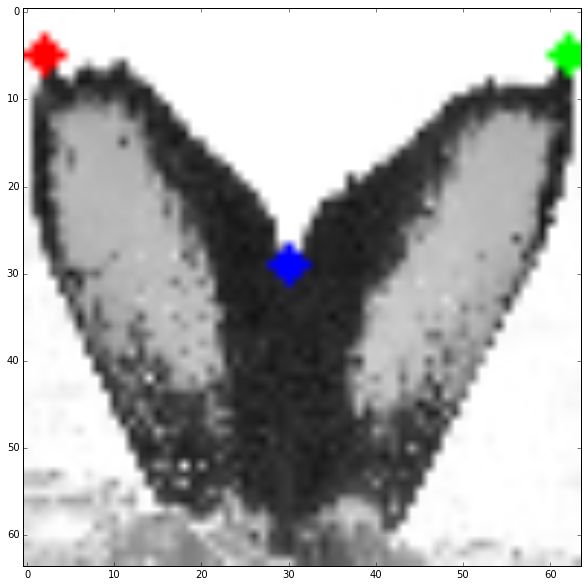

In [130]:
import matplotlib.pyplot as plt
%matplotlib inline
def display_kpgt(img, points):
    color_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(color_img, (points[0,0], points[0,1]), 2, (255,0,0), -1) # left
    cv2.circle(color_img, (points[1,0], points[1,1]), 2, (0,255,0), -1) # right
    cv2.circle(color_img, (points[2,0], points[2,1]), 2, (0,0,255), -1) # notch
    plt.figure(figsize=(10,10))
    plt.imshow(color_img)

    
import random
ind = random.choice(range(len(train_kp_imgs)))
display_kpgt(train_kp_imgs[ind], train_kp_pts[ind])

In [126]:
from train_utils import save_dataset

In [128]:
dset_name = 'all_kpts_64'
save_dataset(join(dataset_loc,'Flukes/kpts/%s' % dset_name),
             (train_kp_imgs, train_kp_pts), 
             (val_kp_imgs, val_kp_pts), 
             (test_kp_imgs, test_kp_pts))


Took 1.18 seconds
